In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import numpy as np
from functools import partial
import random
from collections import Counter
import itertools as it
import operator
from random import randint
import inspect
import math
from Cope import percent
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt
from SquareEnv2 import space2MultiPolygon, SquareEnv
import itertools as it
import time
import numpy as np
import holoviews as hv

from holoviews.streams import Buffer, Stream, Pipe

hv.extension('bokeh', logo=False)

In [2]:
# Run in a seperate notebook
# from time import sleep
# import pygame
# try:
#     pygame.init()
#     pygame.display.init()
#     screen = pygame.display.set_mode((1080, 150))
#     while True:
#         screen.fill('white')
#         pygame.display.update()
#         for e in pygame.event.get():
#             if e.type == pygame.QUIT:
#                 raise Exception
#             pygame.event.pump()
#         sleep(.5)
# finally:
#     pygame.display.quit()
#     pygame.quit()

# Hyperparameters

In [3]:
N=11

# Run Config
total_episodes = 10
max_steps = 2_000
search_space = 5.5
log_path = Path('episodes')
count_path = (Path().home() / '.SquarePackingEpisodeCount.txt')


# Visualizations
update_graph = False
update_table = False
update_display = True
print_on_display = False

graph_update_every = 100
table_update_every = 11
display_update_every = 1

buffer_size = max_steps  # How many steps the dynamic graph holds
buffer_size -= 100
buffer_size /= graph_update_every
buffer_size = round(buffer_size)


# Starting configuration
start_from_promising_config = True
start_config = 'valid'
randomize_start_config = True


# Cooldowns
max_rand = .5  # percent
max_rot = .1
max_shift = .08

min_rand = .01 # percent
min_rot = .000001
min_shift = .000001


# Phases
# The steps at which each phase starts and ends
overlap_phase = (max_steps * 2, -1)
overlap_phase_rand = max_rand

# This isn't a "phase", since it doesn't have an end
revist_highest_phase = 1000
keep_best_amt = 5
steps_until_reset = 500


# How much we allow the probability to be modified, based on the score difference
rand_modify_limit = lambda max_rand: max_rand * .5

rot_and_shift_together = False

cooldown = True
# rand_func  = lambda step: overlap_phase_rand if step > overlap_phase[0] and step < overlap_phase[1] else np.clip(-.000004*step  + max_rand,  _min_rand, max_rand)
rand_func  = lambda step: np.clip(-(max_rand /max_steps)*step + max_rand,  min_rand,  max_rand)
rot_func   = lambda step: np.clip(-(max_rot  /max_steps)*step + max_rot,   min_rot,   max_rot)
shift_func = lambda step: np.clip(-(max_shift/max_steps)*step + max_shift, min_shift, max_shift)

In [4]:
# Set up the log
log_path.mkdir(exist_ok=True)
if not count_path.exists():
    with count_path.open('w') as f:
        f.write('0')
with count_path.open() as f:
    episode_log_count = int(f.read())

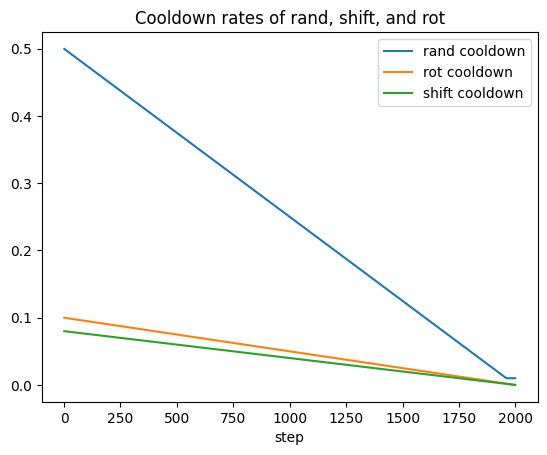

In [5]:
x = np.array(range(1, max_steps if max_steps > 1 else 100_000))
# plt.plot(x, list(map(rand_func, x)), label='random cooldown')
plt.plot(x, rand_func(x), label='rand cooldown')
plt.plot(x, rot_func(x), label='rot cooldown')
plt.plot(x, shift_func(x), label='shift cooldown')
plt.legend()
plt.title('Cooldown rates of rand, shift, and rot')
plt.xlabel('step')
plt.show()
plt.close()

In [6]:
# Create the Enviorment
env = SquareEnv(
    N=N,
    search_space=search_space,
    render_mode="pygame" if update_display else None,
    # render_mode="shapely",
    # The starting rates will always be the highest
    shift_rate=max_shift,
    rot_rate=max_rot,
    max_steps=max_steps,
    bound_method='mixed',
    disallow_overlap=True,
    boundary=0,
    max_overlap=5,
    start_config=start_config,
    show_vars={},
    screen_size=(180, 180),
)
env.offset = 40
env._show_help = False

In [7]:
# Table code
rows = ['N', 'Episode', 'Step', 'Current Reward', 'Side Length', 'Wasted Area', 'Shift Rate', 'Rotation Rate', 'rand', 'Adjusted rand', 'ms/step']
table_pipe = Pipe({'stat':rows, 'value':[None]*len(rows)})
table = hv.DynamicMap(partial(hv.Table, kdims=['stat', 'value']), streams=[table_pipe]).opts(
    height=400,
)

In [8]:
# Graph code
# rand_buffer     = Buffer(np.zeros((0, 2)), length=buffer_size)
# rot_buffer      = Buffer(np.zeros((0, 2)), length=buffer_size)
# shift_buffer    = Buffer(np.zeros((0, 2)), length=buffer_size)
# reward_buffer   = Buffer(np.zeros((0, 2)), length=buffer_size)
side_len_buffer = Buffer(np.zeros((0, 2)), length=buffer_size)
# adj_rand_buffer = Buffer(np.zeros((0, 2)), length=buffer_size)
# overlap_buffer  = Buffer(np.zeros((0, 2)), length=buffer_size)

graph = (
    hv.DynamicMap(partial(hv.Curve, vdims=['Side Length']), streams=[side_len_buffer]).relabel('Side Length').opts(ylim=(3, env.search_space+1.5)) *
    hv.Curve(rand_func(x), vdims=['Cooldowns']).relabel('rand').opts(line_dash='dashed', ylim=(0, .5), alpha=.5) *
    hv.Curve(rot_func(x), vdims=['Cooldowns']).relabel('rot').opts(line_dash='dashed', ylim=(0, .5), alpha=.5) *
    hv.Curve(shift_func(x), vdims=['Cooldowns']).relabel('shift').opts(line_dash='dashed', ylim=(0, .5), alpha=.5)
    # hv.DynamicMap(partial(hv.Curve, vdims=['cooldown']), streams=[rand_buffer]).relabel('rand').opts(line_dash='dashed', ylim=(0, .5), alpha=.5) *
    # hv.DynamicMap(partial(hv.Curve, vdims=['cooldown']), streams=[rot_buffer]).relabel('rot').opts(line_dash='dashed', ylim=(0, .5), alpha=.5) *
    # hv.DynamicMap(partial(hv.Curve, vdims=['cooldown']), streams=[shift_buffer]).relabel('shift').opts(line_dash='dashed', ylim=(0, .5), alpha=.5) *
    # hv.DynamicMap(partial(hv.Curve, vdims=['cooldown']), streams=[adj_rand_buffer]).relabel('Adjusted rand').opts(line_dash='dotted', ylim=(0, .5)) *
    # hv.DynamicMap(partial(hv.Curve, vdims=['Reward']), streams=[reward_buffer]).relabel('Reward').opts(ylim=(-20, -3))
    # hv.DynamicMap(hv.Curve, streams=[side_len_buffer]).relabel('side_len')
    # hv.DynamicMap(hv.Curve, streams=[overlap_buffer]).relabel('overlap')
).opts(padding=0.1, width=650, height=350, show_legend=True, show_grid=True, multi_y=True, xlabel='step', legend_position='bottom_right')

In [9]:
graph+table

BokehModel(combine_events=True, render_bundle={'docs_json': {'c664a947-2329-49ae-bc7a-da73c8f81b44': {'version…

In [19]:
# Construct the best known configuration
A = .04
gap = .8+A
angle = np.deg2rad(90)-np.deg2rad(40.182)
side_len = 3.877084 + A*5
tiny_bottom_gap = .07
rot_half = .7014
# This is *not* the best known configuration, but it's pretty close, and then spread out enough to
# make it not overlap
almost_best_known = np.array([
    .5, .5, 0, # 3 in the bottom left
    1.5+A, .5, 0,
    .5, 1.5+A, 0,
    .5, side_len-.5, 0, # Top Left
    side_len-.5, side_len-.5, 0, # Top right
    2.5+A+tiny_bottom_gap, 0.5, 0, # Straight bottom rightish

    # Rotated
    side_len/2, side_len-rot_half, angle, # Top center
    side_len-rot_half+A, 1.56, angle, # Bottom rightmost
    side_len-rot_half*2+.2, 2.5, angle, # Middle upper right
    2.02, 1.78, angle, # Bottom center
    rot_half+.6, 2 + (side_len-3)/2, angle, # Left
])

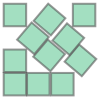

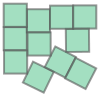

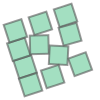

In [20]:
promising_configs = [
    almost_best_known,
    np.array([[1.90891599e+00, 3.18932709e+00, 1.57079633e+00],
        [4.59733526e+00, 3.11965766e+00, 1.06333884e-02],
        [2.90925408e+00, 3.96354843e+00, 0.00000000e+00],
        [2.90689485e+00, 1.52766111e+00, 1.11889505e+00],
        [3.91022243e+00, 4.11797341e+00, 0.00000000e+00],
        [3.85537508e+00, 2.17803469e+00, 1.09580539e+00],
        [1.92372606e+00, 2.18302304e+00, 0.00000000e+00],
        [2.93825600e+00, 2.96170143e+00, 1.90894442e-03],
        [1.90893232e+00, 4.20183180e+00, 1.57079633e+00],
        [4.73213706e+00, 1.69075337e+00, 1.09483670e+00],
        [4.91055385e+00, 4.12903969e+00, 0.00000000e+00]]),
    np.array([[3.35870096, 5.42103571, 0.31535974],
        [1.18570116, 2.65424251, 0.3125785 ],
        [4.14424149, 2.79642918, 0.34706847],
        [0.84009829, 3.59467211, 0.31383164],
        [2.00300767, 4.99386326, 0.31325473],
        [3.60022609, 4.4084419 , 0.27414697],
        [0.66022249, 4.58810847, 0.31310529],
        [1.94584724, 3.84551048, 0.02552858],
        [2.98480485, 3.27762988, 1.51835728],
        [1.47755498, 1.69739964, 0.31302737],
        [2.66515986, 2.13165474, 0.31272677]])
]
for i in promising_configs:
    display(space2MultiPolygon(i))

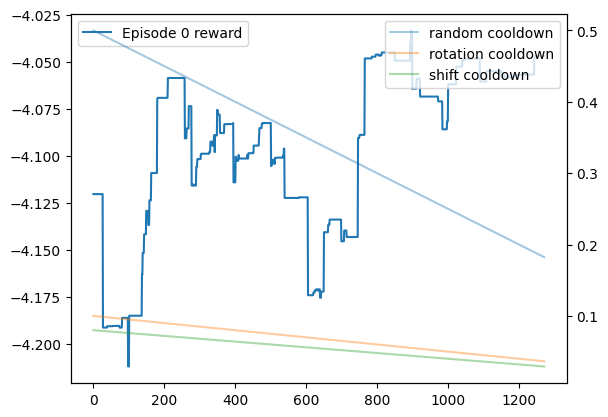

Best side length yet:  4.033340413409889
Best Reward yet:  -4.033340413409889
Best State:
[0.53880878 0.49716454 0.01045981 1.56093702 0.51953832 1.57079633
 0.54150879 1.52814548 1.56414033 0.63841421 3.51951292 1.56280288
 3.37794505 3.52037185 0.         2.66835974 0.50340863 0.
 2.11244915 3.25581732 0.89222343 3.37030705 1.5298963  0.95307838
 2.76460261 2.45695633 0.86523094 2.08883585 1.68882683 0.86157963
 1.40232907 2.4753685  0.7846308 ]


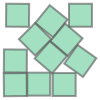

SystemExit: 0

/home/zeke/Software/miniconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
# Main Loop
reward_lists = []
# overlap_lists = []
best_side_len_yet = 11
best_reward_yet = -10000000000
best_state_yet = None
env.disallow_overlap = True

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        if randomize_start_config:
            if percent(50):
                env.start_config = 'valid'
            else:
                env.start_config = 'array'

        options = {}
        if start_from_promising_config:
            options = {'manual': random.choice(promising_configs)}
        prev_state, _ = env.reset(options=options)

        prev_reward = env._get_reward()
        episodic_reward = 0
        reward_lists.append([])
        # overlap_lists.append([0])
        start_time = time.time_ns()
        sum_chance = 0
        best_side_len_this_episode = 11
        best_state_this_episode = None

        if revist_highest_phase:
            top_n_rewards = [-100000000]*keep_best_amt
            top_n_states = [None]*keep_best_amt
            last_step_in_top_n = 0

        # Run/step through a single episodes
        for step in it.count(1):
            if not step % display_update_every and update_display:
                env.render()

            _rand = rand_func(step) if cooldown else max_rand
            _shift = shift_func(step) if cooldown else max_shift
            _rot = rot_func(step) if cooldown else max_rot
            _overlap_phase = step > overlap_phase[0] and step < overlap_phase[1]

            if _overlap_phase:
                env.disallow_overlap = False

            # Make a random action
            action = np.zeros((env.N, 3))
            if rot_and_shift_together:
                singular_action = [
                    random.uniform(-_shift, _shift),
                    random.uniform(-_shift, _shift),
                    random.uniform(-_rot, _rot),
                ]
            else:
                sh = percent(50)
                singular_action = [
                    random.uniform(-_shift, _shift) if sh else 0,
                    random.uniform(-_shift, _shift) if sh else 0,
                    random.uniform(-_rot, _rot) if not sh else 0,
                ]

            action[randint(0, env.N-1)] = singular_action
            action = action.flatten()

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)

            _rand_limit = rand_modify_limit(_rand)
            _chance = _rand + np.clip((prev_reward - reward) * 5, -_rand_limit, _rand_limit)
            # If we're overlapping more than we were before, minimize the odds that we'll keep the movement
            # NOTE: This can't be 0, or else once we overlap during the overlap phase, we won't be able to get out
            if not _overlap_phase:# and info['overlap'] > overlap_lists[ep][-1]:
                _chance = _rand - _rand_limit

            if (
                (
                    (info['overlap'] > 0 and not _overlap_phase)
                    or
                    reward < prev_reward
                )
                # modify the chance of accepting the change based on the amount of reward difference
                and not percent(_chance)
            ):
                # Step back
                state, reward, done, _, info = env.step(-action)

            # If we've finished the overlap phase, and we've gotten to a point where we're no longer
            # overlapping, disable overlap again
            if not env.disallow_overlap and not info['overlap']:
                env.disallow_overlap = True

            if info['len'] < best_side_len_this_episode:
                best_state_this_episode = state
                best_side_len_this_episode = info['len']

            if revist_highest_phase:
                for i, top in enumerate(top_n_rewards):
                    if reward > top:
                        top_n_rewards[i] = reward
                        top_n_states[i] = state
                        last_step_in_top_n = step
                        break

            if revist_highest_phase and step - last_step_in_top_n > steps_until_reset:
                idx = random.choices(range(len(top_n_states)), list(
                    it.accumulate(np.linspace(.5, .1, keep_best_amt), operator.mul)
                ))[0]
                env.squares = top_n_states[idx].reshape((env.N, 3))
                # Not strictly true, but it makes the above if statement work
                last_step_in_top_n = step
                # print(f'{steps_until_reset} steps went by without progress, skipping back to step {last_step_in_top_n}, which had reward {top_n_rewards[idx]:.2f}, which is better than the current reward of {reward:.2f}')


            prev_state = state
            prev_reward = reward

            # ------------------ Not part of the algorithm --------------------
            reward_lists[ep].append(reward)
            # overlap_lists[ep].append(info['overlap'])

            if best_side_len_yet > info['len']:
                best_state_yet = state
                best_side_len_yet = info['len']
                best_reward_yet = reward

            episodic_reward += reward
            sum_chance += _chance

            if print_on_display:
                env.print['e'] = f'Episode {env.reset_count}/{total_episodes}:'
                env.print['step'] = f'Step: {step:.0f}'
                env.print['reward'] = f'Reward: {reward:.3f}'
                env.print['overlap'] = f'Overlap: {info["overlap"]:.5f}'
                env.print['len'] = f'Side Length: {info["len"]:.1f}'
                env.print['wasted'] = f'Wasted Space: {info["wasted"]:.1f}'
                env.print['_rand'] = f'annealing coeff: {_rand:.5f}'
                env.print['_shift'] = f'shift rate: {_shift:.5f}'
                env.print['_rot'] = f'rotation rate: {_rot:.5f}'
                env.print['avg reward'] = f'Avg. Reward for This Episode: {episodic_reward/step:.2f}'
                env.print['phase'] = f"Phase: {'Overlap' if _overlap_phase else 'Main'}"
                env.print['eee'] = f'_rand: {_chance:.2%}'
                env.print['j'] = f'{((time.time_ns() - start_time)/1000_000) / step:.2f}ms / step'

            if not step % graph_update_every and update_graph:
                # rand_buffer.send(    np.array([[step, _rand]]))
                # rot_buffer.send(     np.array([[step, _rot]]))
                # shift_buffer.send(   np.array([[step, _shift]]))
                # reward_buffer.send(  np.array([[step, reward]]))
                side_len_buffer.send(np.array([[step, info['len']]]))
                # adj_rand_buffer.send(np.array([[step, _chance]]))
                # overlap_buffer.send( np.array([[step, info['overlap']]]))

            if not step % table_update_every and update_table:
                data = [None] * len(rows)
                data[rows.index('N')]               = env.N
                data[rows.index('Episode')]         = f'{env.reset_count}/{total_episodes}'
                data[rows.index('Step')]            = step
                data[rows.index('Current Reward')]  = round(reward, 2)
                # data[rows.index('Overlap Area')]    = info["overlap"]
                data[rows.index('Side Length')]     = round(info["len"], 2)
                data[rows.index('Wasted Area')]     = round(info["wasted"], 2)
                data[rows.index('Shift Rate')]      = round(_shift, 2)
                data[rows.index('Rotation Rate')]   = round(_rot, 2)
                data[rows.index('rand')]            = f'{_rand:.1%}'
                data[rows.index('Adjusted rand')]   = f'{sum_chance/table_update_every:.1%}'
                data[rows.index('ms/step')]         = round(((time.time_ns() - start_time)/1000_000) / step, 2)
                # data['Phase']           = 'Overlap' if _overlap_phase else 'Main'
                # data['Avg. Reward for This Episode'] = episodic_reward/step
                table_pipe.send({'stat': rows, 'value': data})
                sum_chance = 0

            if done: break

        # After each episode is done, save the best state in that episode to the log
        with open(log_path / f'episode_{episode_log_count:0>3}-{best_side_len_this_episode:.6f}', 'w') as f:
            f.write(str(best_state_this_episode))
        episode_log_count += 1

finally:
    # KDE gets glitchy if you open and close a window too fast
    time.sleep(.5)
    env.close()

    with count_path.open('w') as f:
        f.write(str(episode_log_count))

    if best_reward_yet is not None and True:
        # env.display(clear=False)

        fig, ax1 = plt.subplots()

        for ep, i in enumerate(reward_lists):
            ax1.plot(i, label=f'Episode {ep} reward')

        ax2 = ax1.twinx()
        x = np.array(range(len(max(reward_lists, key=len))))
        ax2.plot(x, list(map(rand_func, x)), label='random cooldown', alpha=.4)
        ax2.plot(rot_func(x), label='rotation cooldown', alpha=.4)
        ax2.plot(shift_func(x), label='shift cooldown', alpha=.4)
        # for ep, i in enumerate(overlap_lists):
        #     ax2.plot(i, label=f'Episode {ep} overlap')

        ax1.legend()
        ax2.legend()
        # ax1.vlines(overlap_phase, -22, -3)
        plt.show()
        plt.close()
        print('Best side length yet: ', best_side_len_yet)
        print('Best Reward yet: ', best_reward_yet)
        print('Best State:')
        print(best_state_yet)

        display(space2MultiPolygon(best_state_yet.reshape((env.N,3)), 1))

        # save_output(run, 'run9')
